## Ensuring reproducibility

In order to be sure that our experiences can be achieved again we need to fix the random seed for reproducibility:

In [1]:
import numpy as np
CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

## Getting an annotated corpus
The Penn Treebank is an annotated corpus of POS tags. A sample is available in the NLTK python library which contains a lot of corpora that can be used to train and test some NLP models.
First of all, we download the annotated corpus:

In [2]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to C:\Users\Kaushik
[nltk_data]     Dey\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

Then we load the tagged sentences…

In [4]:
from nltk.corpus import treebank
sentences = treebank.tagged_sents(tagset='universal')

… and visualize one:

In [5]:
import random
print(random.choice(sentences))

[('The', 'DET'), ('company', 'NOUN'), ('plugged', 'VERB'), ('itself', 'PRON'), ('right', 'ADV'), ('into', 'ADP'), ('Carter', 'NOUN'), ('campaign', 'NOUN'), ('rhetoric', 'NOUN'), ('about', 'ADP'), ('*', 'X'), ('rebuilding', 'VERB'), ('the', 'DET'), ('South', 'NOUN'), ('Bronx', 'NOUN'), ('and', 'CONJ'), ('kept', 'VERB'), ('*-1', 'X'), ('using', 'VERB'), ('the', 'DET'), ('minority', 'NOUN'), ('--', '.'), ('South', 'NOUN'), ('Bronx', 'NOUN'), ('angle', 'NOUN'), ('through', 'ADP'), ('the', 'DET'), ('Reagan', 'NOUN'), ("'80s", 'NUM'), ('.', '.')]


This is a multi-class classification problem with more than forty different classes. We can check  the POS tagging like: 

In [6]:
tags = set([
    tag for sentence in treebank.tagged_sents() 
    for _, tag in sentence
])
print('nb_tags: %sntags: %s' % (len(tags), tags))

nb_tags: 46ntags: {'NN', '``', 'WP', 'PRP', 'WDT', 'LS', 'NNS', 'RBR', 'RP', 'UH', 'NNP', '#', 'PDT', 'DT', 'RB', 'TO', 'WRB', '-NONE-', 'NNPS', 'IN', 'VBN', 'JJ', "''", 'MD', 'CC', 'VBZ', 'FW', '-RRB-', ',', 'VB', 'WP$', '.', 'SYM', 'VBD', 'VBG', ':', 'VBP', 'PRP$', 'POS', 'RBS', 'CD', 'JJS', '$', '-LRB-', 'EX', 'JJR'}


## Datasets preprocessing for supervised learning
We split our tagged sentences into 3 datasets :
- a training dataset which corresponds to the sample data used to fit the model,
- a validation dataset used to tune the parameters of the classifier, for example to choose the number of units in the neural network,
- a test dataset used only to assess the performance of the classifier.

In [7]:
train_test_cutoff = int(.80 * len(sentences)) 
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

## Feature engineering
Our set of features is very simple.
- For each term we create a dictionnary of features depending on the sentence where the term has been extracted from. These properties could include informations about previous and next words as well as prefixes and suffixes.
- For training, validation and testing sentences, we split the attributes into X (input variables) and y (output variables).
- We map our list of sentences to a list of dict features.

In [8]:
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.
        :param sentence_terms: [w1, w2, ...] 
        :type sentence_terms: list
        :param index: the index of the word 
        :type index: int
        :return: dict containing features
        :rtype: dict
    """
    term = sentence_terms[index]
    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }
def untag(tagged_sentence):
    """ 
    Remove the tag for each tagged term.
    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]
def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.
    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return: 
    """
    X, y = [], []
    for pos_tags in tagged_sentences:
            for index, (term, class_) in enumerate(pos_tags):
                # Add basic NLP features for each sentence term
                X.append(add_basic_features(untag(pos_tags), index))
                y.append(class_)
    return X, y

X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)


## Features encoding
Our neural network takes vectors as inputs, so we need to convert our dict features to vectors.
sklearn builtin function `DictVectorizer` provides a straightforward way to do that.

In [9]:
from sklearn.feature_extraction import DictVectorizer
# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)
# Convert dict features to vectors
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

Our y vectors must be encoded. The output variable contains 49 different string values that are encoded as integers.

In [10]:
from sklearn.preprocessing import LabelEncoder
# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)
# Encode class values as integers
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

And then we need to convert those encoded values to dummy variables (one-hot encoding).

In [11]:
# Convert integers to dummy variables (one hot encoded)
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

We want to create one of the most basic neural networks: the Multilayer Perceptron. This kind of linear stack of layers can easily be made with the Sequential model. This model will contain an input layer, an hidden layer, and an output layer.
To overcome overfitting, we use dropout regularization. We set the dropout rate to 20%, meaning that 20% of the randomly selected neurons are ignored during training at each update cycle.
We use Rectified Linear Units (ReLU) activations for the hidden layers as they are the simplest non-linear activation functions available.
For multi-class classification, we may want to convert the units outputs to probabilities, which can be done using the softmax function. We decide to use the categorical cross-entropy loss function.
Finally, we choose Adam optimizer as it seems to be well suited to classification tasks.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Creating a wrapper between Keras API and Scikit-Learn
Keras provides a wrapper called KerasClassifier which implements the Scikit-Learn classifier interface.
All model parameters are defined below. We need to provide a function that returns the structure of a neural network (build_fn).
The number of hidden neurons and the batch size are choose quite arbitrarily. We set the number of epochs to 5 because with more iterations the Multilayer Perceptron starts overfitting (even with Dropout Regularization).

In [13]:
#Scikeras Training

from scikeras.wrappers import KerasClassifier
model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'validation_split': 0.0,
    'shuffle': True
}
clf = KerasClassifier(**model_params)


In [14]:
# tf training

model = build_model(X_train.shape[1],512,y_train.shape[1])

## Training our Keras model
Finally, we can train our Multilayer perceptron on train dataset.


In [15]:
res = clf.fit(X_train, y_train)

C:\Python310\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
239/239 [==============================] - 38s 154ms/step - loss: 0.3996 - accuracy: 0.8827
Epoch 2/5
239/239 [==============================] - 33s 138ms/step - loss: 0.0723 - accuracy: 0.9769
Epoch 3/5
239/239 [==============================] - 34s 141ms/step - loss: 0.0408 - accuracy: 0.9874
Epoch 4/5
239/239 [==============================] - 34s 142ms/step - loss: 0.0263 - accuracy: 0.9915
Epoch 5/5
239/239 [==============================] - 34s 140ms/step - loss: 0.0275 - accuracy: 0.9914


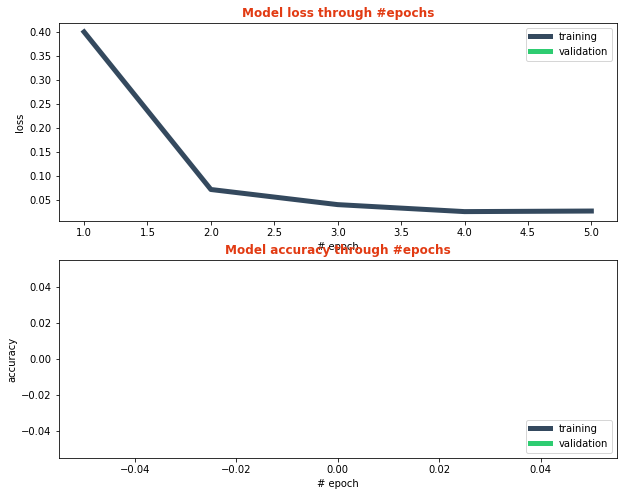

In [16]:
import matplotlib.pyplot as plt
def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')
plot_model_performance(
    train_loss=res.history_.get('loss', []),
    train_acc=res.history_.get('acc', []),
    train_val_loss=res.history_.get('val_loss', []),
    train_val_acc=res.history_.get('val_acc', [])
)

In [17]:
score = clf.score(X_test, y_test)
print(score)

79/79 [==============================] - 5s 59ms/step
0.963920355307151


## Using the model



In [34]:
x_see, y_see = transform_to_dataset(training_sentences)

for i in range(10):
    print(x_see[i]['term'], ' POS:', y_see[i])

Mrs.  POS: NOUN
Ward  POS: NOUN
says  POS: VERB
that  POS: ADP
when  POS: ADV
the  POS: DET
cheating  POS: NOUN
was  POS: VERB
discovered  POS: VERB
*-4  POS: X


In [45]:
# dict_vectorizer.transform()
input = dict_vectorizer.transform()
output = clf.predict(input)
[ pos for pos in label_encoder.inverse_transform([int(y) for y in  output]) if pos != '.'][0]

'ADJ'

## Save the Keras model
Saving a Keras model is pretty simple as a method is provided natively:

In [47]:
import pickle
with open('text-pos-model', 'wb') as files:
    pickle.dump(clf, files)

INFO:tensorflow:Assets written to: C:\Users\KAUSHI~1\AppData\Local\Temp\tmp2_8_e2dv\assets
